In [1]:
%matplotlib inline
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
colors = ['darkgreen','violet','darkred','gold','darkblue','silver','burlywood','black','dodgerblue']

In [2]:
# Get directories with valid/completed experiments
def get_expt_dirs(src_dir):
    test_dirs = sorted(os.listdir(src_dir))
    test_dir_dict = {}
    for curr in test_dirs:
        full_path_curr = os.path.join(src_dir, curr)
        if 'results.txt' in os.listdir(full_path_curr):
            test_dir_dict[len(test_dir_dict)] = full_path_curr
        else:
            sub_dirs = [os.path.join(full_path_curr, x) 
                        for x in os.listdir(full_path_curr) 
                        if os.path.isdir(os.path.join(full_path_curr, x))]

            temp_dict = {}
            for new_dir in sub_dirs:
                temp_dict = get_expt_dirs(new_dir)
                for temp_dict_key in temp_dict:
                    test_dir_dict[len(test_dir_dict)] = temp_dict[temp_dict_key]

    return test_dir_dict


In [3]:
def get_summary_dicts(test_dir_dict):
         
    # Read cfg files in chosen dirs to create dict with summarized info
    summary_dicts = {}
    for curr in test_dir_dict:
        summary_dict = {}
        metadata_dir = os.path.join(test_dir_dict[curr],
                                    'metadata')
        
        xx = configparser.ConfigParser()
        cfg_files = [os.path.join(metadata_dir, x ) 
                     for x in os.listdir(metadata_dir) if x[-4:] == '.cfg']
        xx.read(cfg_files)
        xx_dict = xx._sections

        summary_dict['Arch'] = xx_dict['NetParams']['arch_module']
        summary_dict['Optimizer'] = xx_dict['OptimizerParams']['optimizer']
        if 'data_loader' in xx_dict['ExptFiles']:
            summary_dict['Data'] = xx_dict['ExptFiles']['data_loader']
        else:    
            summary_dict['Data'] = xx_dict['ExptFiles']['data_generator']
            
        summary_dict['Epochs'] = xx_dict['ExptParams']['epochs']
        
        if 'MetricParams' in xx_dict:
            summary_dict['Acc_Metric']= xx_dict['MetricParams']['accuracy_metric']
            summary_dict['Encoding'] = xx_dict['EncodingModuleParams']['encoding_module'] + "_" + \
                                       xx_dict['Encoding']['nb_code_bits']
        else:
            enc_file = xx_dict['ExptFiles']['encoding_cfg']
            yy = ConfigParser.ConfigParser()
            yy.read(os.path.join('.',enc_file))
            yy_dict = yy._sections
            summary_dict['Encoding'] = yy_dict['EncodingModuleParams']['encoding_module'] + "_" + \
                                       yy_dict['Encoding']['nb_code_bits']
            summary_dict['Acc_Metric']= yy_dict['MetricParams']['accuracy_metric'] 

        with open(os.path.join(test_dir_dict[curr], 'results.txt'), 'r') as f:
            fl = f.readlines()
            tr_acc = []
            va_acc = []
            for curr_line in fl:
                info = curr_line.split(' ')
                tr_acc.append(float(info[3]))
                va_acc.append(float(info[9]))
        summary_dict['Top_Val_Acc'] = max(va_acc)
        summary_dict['Top_Train_Acc'] = max(tr_acc)
        summary_dict['Full_Path'] = test_dir_dict[curr]
        summary_dicts[test_dir_dict[curr].split('/')[-1]] = summary_dict   
    return summary_dicts


In [4]:
def get_dataframe(summary_dicts):

    # Create dataframe
    summary_df = pd.DataFrame.from_dict(summary_dicts).transpose()
    summary_df.style.set_properties(**{'text-align': 'center'})
    new_order = [7,6,4,0,5,3,1,2,8]
    summary_df = summary_df[summary_df.columns[new_order]]
    summary_df.sort_values(by=['Top_Val_Acc'], inplace=True, ascending=False)
    summary_df = summary_df[(summary_df.Top_Val_Acc > 0.20)]
    summary_df = summary_df.reset_index()

    return summary_df 

In [5]:
def get_plotdicts(summary_df, chosen_rows):
    plot_dict_list = []
    for curr_row in chosen_rows:
        expt_path = summary_df.iloc[curr_row,9]
        curr_file = os.path.join(expt_path,  'results.txt')
        with open(curr_file,'r') as f:
            plot_dict = dict()
            fl = f.readlines()
            for curr_line in fl:
                curr_line = curr_line.split()
                epoch = int(curr_line[1][:-1])
                train_acc = float(curr_line[3])
                test_acc = float(curr_line[7])
                plot_dict[epoch] = {'train': train_acc, 'test': test_acc}
            plot_dict['name'] = summary_df.iloc[curr_row,0]
            plot_dict_list.append(plot_dict)
    return plot_dict_list

In [6]:
def get_acc_curves(plot_dict_list, colors=colors):
    curve_dict_list = []
    for ctr, curr_plot in enumerate(plot_dict_list):
        num_points = len(curr_plot)
        epochs = sorted([x for x in curr_plot if isinstance(x, int)])
        
        tr_data = [curr_plot[x]['train'] for x in epochs]
        te_data = [curr_plot[x]['test'] for x in epochs]
        curve_dict = {'epochs':epochs,
                      'train':tr_data,
                      'test':te_data,
                      'color': colors[ctr],
                      'expt_id': curr_plot['name'],
                      'name': curr_plot['name']}
        curve_dict_list.append(curve_dict)
    return curve_dict_list
        
    

In [7]:
def plot(start, stop, data_dicts, curve_type='test'):
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    if curve_type == 'test':
        ylabel = "Test Acc"
    elif curve_type == 'train':
        ylabel = "Train Acc"
        
    for curr_set in data_dicts:
        ax1.plot(curr_set['epochs'][start:stop],
                 curr_set[curve_type][start:stop],
                 label = curr_set['name'],
                 color=curr_set['color']
                )
    ax1.legend(loc='center right', bbox_to_anchor=(1.75,0.5))
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(curve_type, fontsize=12)
    

In [8]:
def comparison_plot(summary_df, expt_list, epoch_range, names=[]):
    plotds = get_plotdicts(summary_df, expt_list)
    accs = get_acc_curves(plotds)
    if names != [] and len(names) == len(accs):
        for ctr in range(len(names)):
            accs[ctr]['name'] = names[ctr]
    plot(epoch_range[0], epoch_range[1], accs)
    
    

In [9]:
def get_expt_data(root_dir):
    x = get_expt_dirs(root_dir)
    y = get_summary_dicts(x)
    z = get_dataframe(y)
    return z

In [10]:
z = get_expt_data('./opt_tfer_expts_5')
z

,index,Top_Train_Acc,Top_Val_Acc,Acc_Metric,Arch,Encoding,Epochs,Optimizer,Data,Full_Path
0,balin_cifar_100_expts__v0,0.7821,0.4435,hot_bit,cifar100_keras_net,n_hot_encoding_65,100,sgd,cifar100_src_living_vs_notliving,./opt_tfer_expts_5/cifar_100_expts/keras_cifar...
1,balin_cifar_100_expts_v1,0.7726,0.4414,hot_bit,cifar100_keras_net,n_hot_encoding_65,100,sgd,cifar100_src_living_vs_notliving,./opt_tfer_expts_5/cifar_100_expts/keras_cifar...
2,balin_cifar_100_expts_v0,0.7762,0.4391,hot_bit,cifar100_keras_net,n_hot_encoding_65,100,sgd,cifar100_src_living_vs_notliving,./opt_tfer_expts_5/cifar_100_expts/keras_cifar...
3,balin_cifar_100_expts_*,0.7639,0.4255,hot_bit,cifar100_keras_net,n_hot_encoding_65,100,sgd,cifar100_src_living_vs_notliving,./opt_tfer_expts_5/cifar_100_expts/keras_cifar...


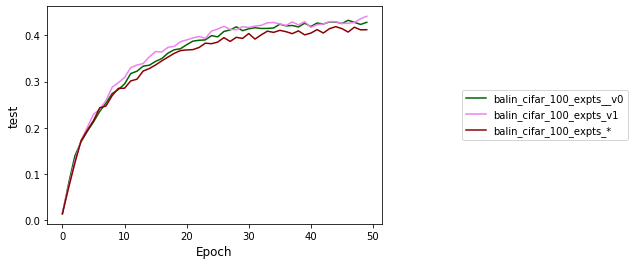

In [11]:
comparison_plot(z, [0,1,3], [0,50])